In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PIL import Image
from pathlib import Path

import h5py
from smt.sampling_methods import LHS
import emcee

import torch
from CosmicNetwork import CosmicNetwork_v2

import camb

from tqdm import tqdm

In [3]:
# ---------------------------------------------------------------------------------------
# Planck curve of best fit --------------------------------------------------------------
# ---------------------------------------------------------------------------------------

# reduced hubble constant
h          = 0.6736
h_squared  = 0.6736**2 

T_CMB      = 2.7255
OMEGA_B0   = 0.02237
OMEGA_CDM0 = 0.1200
OMEGA_G0   = 2.471e-5
OMEGA_UR0  = 1.709e-5

l_max      = 1000
l_range    = np.arange(2, l_max+ 1)


# CAMB  and CLASS Planck parameters:
params = {
    "omega_b"   : OMEGA_B0,
    "omega_c"   : OMEGA_CDM0,
    "omega_g"   : OMEGA_G0,
    "omega_ur"  : OMEGA_UR0,
    "omega_k"   : 0.0,
    "h"         : h,
    "H0"        : 67.36,
    "YHe"       : 0.2471,
    "tau"       : 0.054,
    "As"        : 2.1e-9,
    "n_s"       : 0.965
    }

# ---------------------------------------------------------------------------------------
# Fast Fourier Transform 2d -------------------------------------------------------------
# ---------------------------------------------------------------------------------------

N_MAP     = 512

rng       = np.random.default_rng(42)
eps_fixed = (rng.normal(size=(N_MAP, N_MAP))
             + 1j * rng.normal(size=(N_MAP, N_MAP)))

# ---------------------------------------------------------------------------------------
# Torch parameters-----------------------------------------------------------------------
# ---------------------------------------------------------------------------------------

DEVICE    = "cpu"

In [4]:
# ---------------------------------------------------------------------------------------
# Helper functions for CMB --------------------------------------------------------------
# ---------------------------------------------------------------------------------------

def tcmb_omega_g(omega_g):
    return T_CMB * (omega_g/OMEGA_G0)**0.25

def neff_omega_ur(omega_ur, t_cmb):
    scale = (t_cmb / T_CMB)**4
    return 3.046 * omega_ur / (OMEGA_UR0 * scale)

def camb_dl(params, lmax):
    omega_b  = params["omega_b"]
    omega_c  = params["omega_c"]
    omega_g  = params["omega_g"]
    omega_ur = params["omega_ur"]
    
    t_cmb    = tcmb_omega_g(omega_g)
    Neff     = neff_omega_ur(omega_ur, t_cmb)
    
    pars     = camb.CAMBparams()
    pars.set_cosmology(H0    = params["H0"], 
                       ombh2 = omega_b,
                       omch2 = omega_c,
                       omk   = params["omega_k"],
                       YHe   = params["YHe"],
                       tau   = params["tau"],
                       TCMB  = t_cmb)

    pars.Neff = Neff    
    pars.num_massive_neutrinos   = 0
    
    pars.InitPower.set_params(As = params["As"], ns = params["n_s"])
    pars.set_accuracy(AccuracyBoost=1, lAccuracyBoost=1, lSampleBoost=1)
    pars.set_for_lmax(lmax, lens_potential_accuracy=0)

    results = camb.get_results(pars)
    Dl_camb = results.get_cmb_power_spectra(pars, CMB_unit="muK", lmax=lmax)["unlensed_scalar"][:, 0]
    return Dl_camb[2:lmax + 1]

# ---------------------------------------------------------------------------------------
# model_helper --------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------

def get_model_input(omega_b=None, omega_cdm=None, omega_g=None, omega_ur=None):

    omega_b   = OMEGA_B0   if omega_b   is None else omega_b
    omega_cdm = OMEGA_CDM0 if omega_cdm is None else omega_cdm
    omega_g   = OMEGA_G0   if omega_g   is None else omega_g
    omega_ur  = OMEGA_UR0  if omega_ur  is None else omega_ur

    x = [omega_b, omega_cdm, omega_g, omega_ur]

    return torch.tensor([x], dtype=torch.float32)

def load_pca_components(pca_path, device="cpu"):

    with h5py.File(pca_path, "r") as f:
        basis = torch.tensor(f["basis"][:], dtype=torch.float32, device=device)
        mean  = torch.tensor(f["mean_spectrum"][:], dtype=torch.float32, device=device)
        var   = torch.tensor(f["explained_variance"][:], dtype=torch.float32, device=device)
    
    std = torch.sqrt(var)  
    return [basis, mean, std]

# ---------------------------------------------------------------------------------------
# Loading Model -------------------------------------------------------------------------
# ---------------------------------------------------------------------------------------

class CosmicNet: 

    def __init__(self, pca_path, model_weight_path,  in_dim=4, out_dim=999, lay_dim=192, hid_lay=4):

        # Load Model
        self.model  = CosmicNetwork_v2(in_dim, out_dim, lay_dim, hid_lay)
        ckpt        = torch.load(model_weight_path, map_location="cpu")
        self.model.load_state_dict(ckpt["model_state"])
        self.model.eval()
        
        # Load pca components for reconstruction
        self.pca    = load_pca_components(pca_path, device="cpu")
        
        self.lmax   = out_dim + 1
        self.ells   = np.arange(2, 2 + self.lmax, dtype=np.int64)

    # Model reconstruction 
    @torch.no_grad()
    def predict_log_spectrum_unified(self, x):

        basis, mean, std = self.pca
        B = torch.as_tensor(basis, dtype=torch.float32, device=x.device)  # [C, L]
        M = torch.as_tensor(mean,  dtype=torch.float32, device=x.device)  # [L]
        S = torch.as_tensor(std,   dtype=torch.float32, device=x.device)  # [C]
        coeffs_std = self.model(x)                                           # [B, C]

        return (coeffs_std * S) @ B + M

    @torch.no_grad()
    def predict_D_ell_unified(self, x, clamp_log=(-20.0, 20.0)):
        
        log_spec = self.predict_log_spectrum_unified(x)  
        log_spec = torch.clamp(log_spec, clamp_log[0], clamp_log[1]).squeeze(0).cpu().numpy()

        return np.exp(log_spec)

    # Model Evaluation Metrics
    
    @staticmethod
    def percent_error(pred, truth):
        return 100.0 * (pred - truth) / truth 
    
    @classmethod
    def abs_percent_error(cls, pred, truth):
        return np.abs(cls.percent_error(pred, truth))
    
    @classmethod
    def summary_from_array(cls, pred, truth):
        x = cls.abs_percent_error(pred, truth).ravel()
        return dict(
            mean=float(np.mean(x)),
            median=float(np.median(x)),
            p95=float(np.percentile(x, 95)),
            p99=float(np.percentile(x, 99)),
            max=float(np.max(x)),
        )
    
    
    def evaluation(self, x, params):
        
        # Camb defining parameters
        camb_params = params.copy()
        
        camb_params["omega_b"]   = float(x[0, 0])
        camb_params["omega_c"]   = float(x[0, 1])
        camb_params["omega_g"]   = float(x[0, 2])
        camb_params["omega_ur"]  = float(x[0, 3])

        true        = camb_dl(camb_params, self.lmax)

        # Model parameters 

        pred        = self.predict_D_ell_unified(x) 
        return self.summary_from_array(pred, true)
    
    
    def evaluate_dataset(self, h5_path, lmax=1000):

        results, omegas = [], []

        with h5py.File(h5_path, "r") as f:
            ob = f["omega_b"][:]
            oc = f["omega_c"][:]
            og = f["omega_g"][:]
            our = f["omega_ur"][:]
            d_ell = f["d_ell"][:]  # <-- assuming this is log(D_ell) [N, L]
            ells = f["ell"][:]    # optional, if stored

            for i in tqdm(range(len(ob))):
                # Surrogate input
                x = torch.tensor([[ob[i], oc[i], og[i], our[i]]], dtype=torch.float32)

                # True spectrum (convert log back to linear D_ell)
                true = np.exp(d_ell[i, :lmax-1])  

                # Surrogate prediction
                pred = self.predict_D_ell_unified(x)

                # Store errors
                results.append(self.summary_from_array(pred, true))
                omegas.append([ob[i], oc[i], og[i], our[i]])

        return results, np.array(omegas)
    
    
    
    
    def plot_error_map(self, results, omegas, param_index=0, stat="median", nbins=50):

        vals = omegas[:, param_index]
        errs = np.array([r[stat] for r in results])

        bins = np.linspace(vals.min(), vals.max(), nbins+1)
        digitized = np.digitize(vals, bins)

        bin_centers, bin_errs = [], []
        for i in range(1, nbins+1):
            mask = digitized == i
            if mask.sum() > 0:
                bin_centers.append(vals[mask].mean())
                bin_errs.append(errs[mask].mean())

        plt.plot(bin_centers, bin_errs, marker="o")
        plt.xlabel([r"$\Omega_b h^2$", r"$\Omega_{\mathrm{cdm}} h^2$", 
                    r"$\Omega_\gamma h^2$", r"$\Omega_{\mathrm{ur}} h^2$"][param_index])
        plt.ylabel(f"{stat} % error")
        plt.title(f"Error vs parameter ({stat})")
        plt.grid(True)
        plt.show()

    @staticmethod
    def summarize_results(results):

        metrics = {k: [r[k] for r in results] for k in results[0].keys()}
        summary = {f"{k}_median": np.median(v) for k,v in metrics.items()}
        return summary



In [5]:
pca_20_path         = "merged_complete_20_pca.h5"
model_20_weights    = "weights-sage-puddle-1.pt" 
model_20            = CosmicNet(pca_20_path, model_20_weights,
                                in_dim=4, out_dim=20, lay_dim=192, hid_lay=4)

pca_50_path         = "pca_recon_assets.h5"
model_50_weights    = "weights-different-dragon-2.pt" 
model_50            = CosmicNet(pca_50_path, model_50_weights,
                                in_dim=4, out_dim=50, lay_dim=192, hid_lay=4)

In [6]:
# Evaluate both models
results_20, omegas_20 = model_20.evaluate_dataset("val_2000_clean.h5", lmax=1000)
results_50, omegas_50 = model_50.evaluate_dataset("val_2000_clean.h5", lmax=1000)

# Summaries
summary_20 = model_20.summarize_results(results_20)
summary_50 = model_50.summarize_results(results_50)

print("20 PCA components summary:", summary_20)
print("50 PCA components summary:", summary_50)

100%|██████████| 2000/2000 [00:01<00:00, 1219.75it/s]

20 PCA components summary: {'mean_median': np.float64(2.8407034873962402), 'median_median': np.float64(2.241531014442444), 'p95_median': np.float64(7.175663471221924), 'p99_median': np.float64(7.855393886566162), 'max_median': np.float64(8.386003017425537)}
50 PCA components summary: {'mean_median': np.float64(2.8117231130599976), 'median_median': np.float64(2.2099368572235107), 'p95_median': np.float64(7.060406923294067), 'p99_median': np.float64(7.785070419311523), 'max_median': np.float64(8.272846221923828)}


In [7]:
# Evaluate both models
results_20, omegas_20 = model_20.evaluate_dataset("core_eval.h5", lmax=1000)
results_50, omegas_50 = model_50.evaluate_dataset("core_eval.h5", lmax=1000)

# Summaries
summary_20 = model_20.summarize_results(results_20)
summary_50 = model_50.summarize_results(results_50)

print("20 PCA components summary:", summary_20)
print("50 PCA components summary:", summary_50)

100%|██████████| 5000/5000 [00:03<00:00, 1358.35it/s]


20 PCA components summary: {'mean_median': np.float64(0.8318924009799957), 'median_median': np.float64(0.7417661845684052), 'p95_median': np.float64(1.730817973613739), 'p99_median': np.float64(1.9120332598686218), 'max_median': np.float64(2.154728055000305)}
50 PCA components summary: {'mean_median': np.float64(0.5292330682277679), 'median_median': np.float64(0.47389595210552216), 'p95_median': np.float64(1.240946352481842), 'p99_median': np.float64(1.563619613647461), 'max_median': np.float64(1.9265666007995605)}


Mock Planck-like fiducial = {'omega_b': 0.022369999438524246, 'omega_c': 0.11999999731779099, 'omega_g': 2.4709999706828967e-05, 'omega_ur': 1.709000025584828e-05}


100%|██████████| 8000/8000 [00:37<00:00, 213.55it/s]


post-burn chain shape: (89600, 4)
mean acceptance fraction: 0.4935446428571429

=== Posterior summaries (mean [95% CI]) ===
omega_b    = 0.0225301  [0.0221986, 0.0228531]
omega_c    = 0.120152  [0.119326, 0.120984]
omega_g    = 2.45133e-05  [2.30179e-05, 2.59738e-05]
omega_ur   = 1.63824e-05  [1.30344e-05, 1.99514e-05]
T_CMB[K]   = 2.71972  [2.67759, 2.7597]
N_eff      = 2.94756  [2.29703, 3.66946]


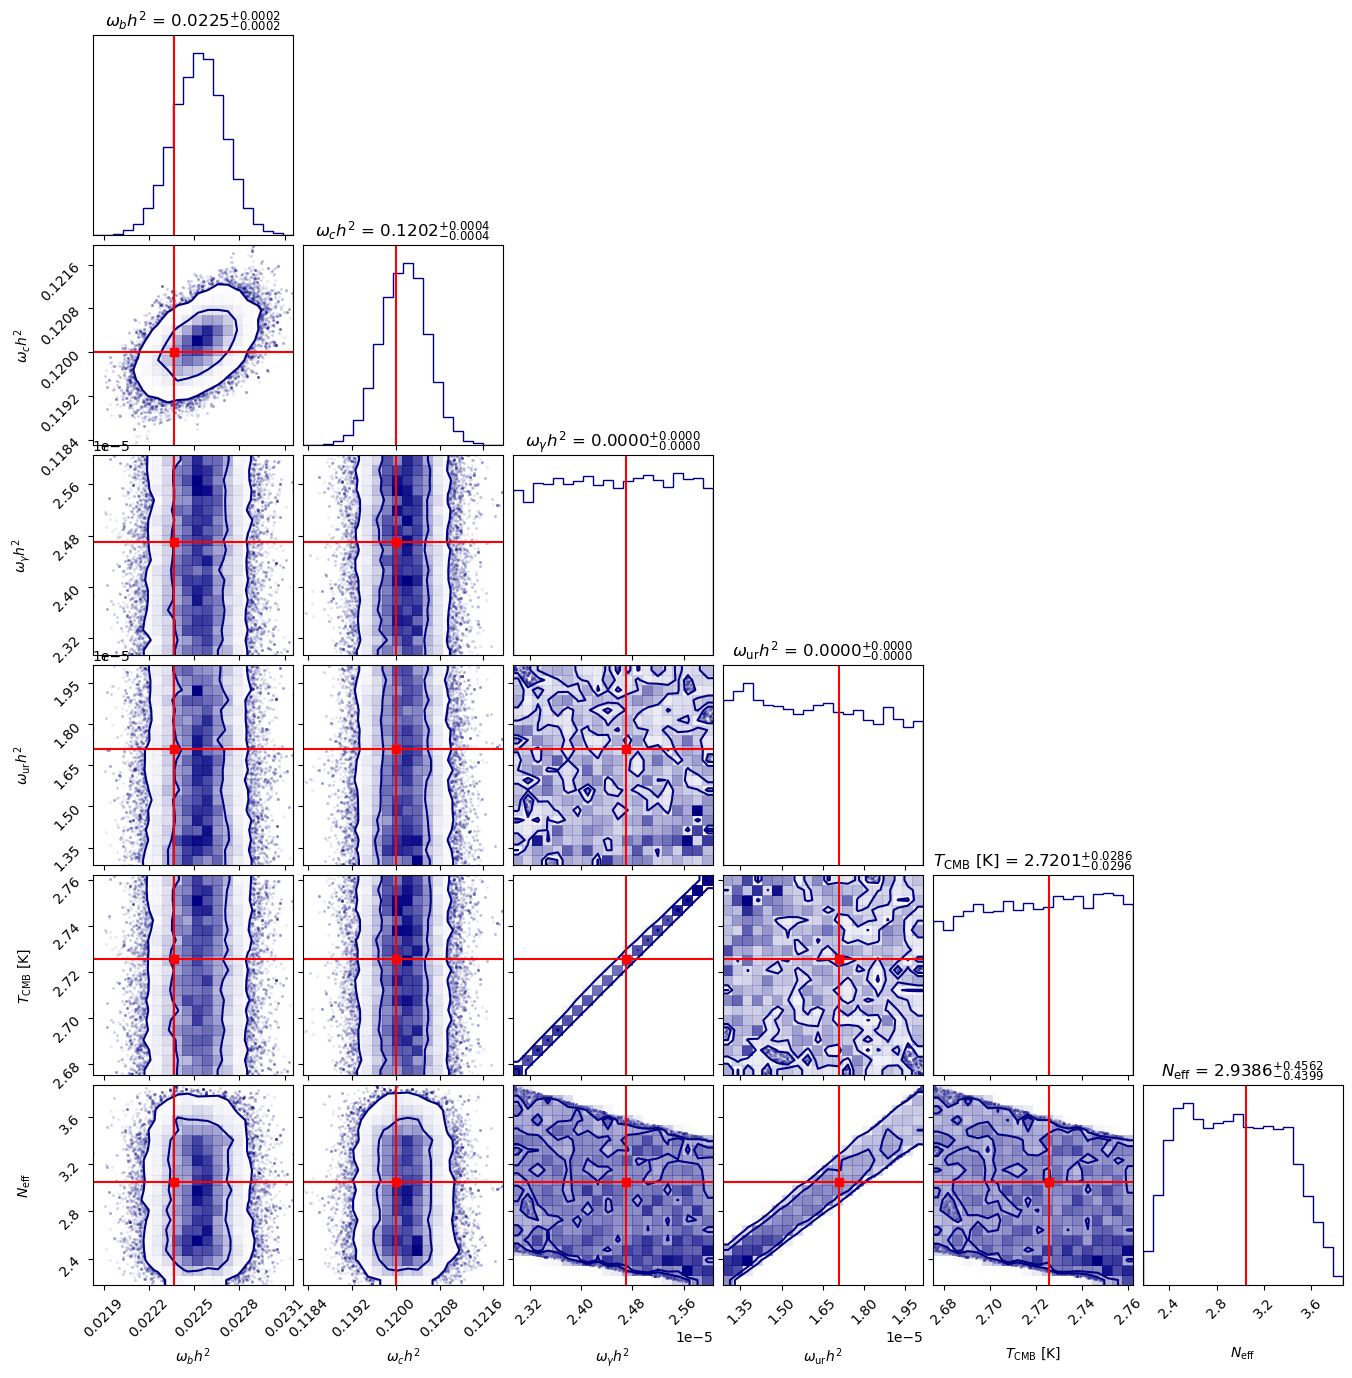

In [9]:
import h5py, torch, numpy as np, emcee, corner, matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────
# Load validation set & pick a Planck-like mock
# ─────────────────────────────────────────────────────────────────────
data_path = "val_2000_clean.h5"
with h5py.File(data_path, "r") as f:
    ob, oc, og, our = f["omega_b"][:], f["omega_c"][:], f["omega_g"][:], f["omega_ur"][:]
    dlog = f["d_ell"][:]   # log(D_ell), shape [N, 999]

ell = np.arange(2, 1001, dtype=int)  # ℓ=2..1000 (length 999)

planck = np.array([OMEGA_B0, OMEGA_CDM0, OMEGA_G0, OMEGA_UR0], dtype=float)
grid   = np.stack([ob, oc, og, our], axis=1)
idx    = int(np.argmin(np.linalg.norm(grid - planck[None, :], axis=1)))

D_obs = np.exp(dlog[idx])  # observed D_ell
theta_star = dict(omega_b=float(ob[idx]), omega_c=float(oc[idx]),
                  omega_g=float(og[idx]), omega_ur=float(our[idx]))
print("Mock Planck-like fiducial =", theta_star)

# ─────────────────────────────────────────────────────────────────────
# Choose surrogate (flip between model_20 / model_50)
# ─────────────────────────────────────────────────────────────────────
net = model_50  # or: net = model_20

def surrogate(theta):
    x = torch.tensor([[theta["omega_b"], theta["omega_c"], theta["omega_g"], theta["omega_ur"]]],
                     dtype=torch.float32)
    return net.predict_D_ell_unified(x)  # numpy array, length 999

# ─────────────────────────────────────────────────────────────────────
# Posterior pieces (minimal)
# ─────────────────────────────────────────────────────────────────────
f_sky = 0.6
N_ell = np.zeros_like(D_obs)  # TT-only, CV-limited

def cosmic_variance(D, N, ell, fsky):
    # Var(D_ell) = 2/[(2ℓ+1) f_sky] * (D_ell + N_ell)^2
    return 2.0 / ((2.0 * ell + 1.0) * fsky) * (D + N) ** 2

# flat box priors from dataset (with small padding)
pad = 0.02
box = {
    "omega_b": (ob.min() - pad*(ob.max()-ob.min()),  ob.max() + pad*(ob.max()-ob.min())),
    "omega_c": (oc.min() - pad*(oc.max()-oc.min()),  oc.max() + pad*(oc.max()-oc.min())),
    "omega_g": (og.min() - pad*(og.max()-og.min()),  og.max() + pad*(og.max()-og.min())),
    "omega_ur":(our.min()- pad*(our.max()-our.min()),our.max()+ pad*(our.max()-our.min())),
}
param_order = ["omega_b", "omega_c", "omega_g", "omega_ur"]

def log_prob(theta_vec):
    # vector -> dict
    th = {k: float(theta_vec[i]) for i, k in enumerate(param_order)}
    # prior (flat box)
    for k, (lo, hi) in box.items():
        if not (lo <= th[k] <= hi):
            return -np.inf
    # likelihood (Gaussian, drop log-normalization)
    D_th = surrogate(th)
    V    = cosmic_variance(D_th, N_ell, ell, f_sky)
    r    = D_obs - D_th
    return -0.5 * np.sum(r * r / V)

# ─────────────────────────────────────────────────────────────────────
# Run MCMC (robust burn-in)
# ─────────────────────────────────────────────────────────────────────
ndim, nwalk, nsteps = len(param_order), 14, 8000
rng = np.random.default_rng(0)

# init near fiducial (fast sanity check). For a robust test, init uniformly in the box.
p0 = np.array([[theta_star[k] for k in param_order] for _ in range(nwalk)])
p0 += rng.normal(0, [1e-4, 3e-4, 3e-7, 3e-7], size=p0.shape)

sampler = emcee.EnsembleSampler(nwalk, ndim, log_prob)
sampler.run_mcmc(p0, nsteps, progress=True)

raw   = sampler.get_chain()                  # [nsteps, nwalk, ndim]
burn  = max(200, raw.shape[0] // 5)          # ~20% burn-in (at least 200)
chain = raw[burn:].reshape(-1, ndim)         # flatten walkers
print("post-burn chain shape:", chain.shape)
print("mean acceptance fraction:", np.mean(sampler.acceptance_fraction))

# ─────────────────────────────────────────────────────────────────────
# Derived: T_CMB and N_eff
# ─────────────────────────────────────────────────────────────────────
omega_b_s, omega_c_s, omega_g_s, omega_ur_s = chain.T
T_samps    = tcmb_omega_g(omega_g_s)
Neff_samps = neff_omega_ur(omega_ur_s, T_samps)

def mean_ci(x): 
    return float(np.mean(x)), *map(float, np.quantile(x, [0.025, 0.975]))

labels_print = param_order + ["T_CMB[K]", "N_eff"]
arrays_print = [omega_b_s, omega_c_s, omega_g_s, omega_ur_s, T_samps, Neff_samps]

print("\n=== Posterior summaries (mean [95% CI]) ===")
for k, arr in zip(labels_print, arrays_print):
    m, lo, hi = mean_ci(arr)
    print(f"{k:10s} = {m:.6g}  [{lo:.6g}, {hi:.6g}]")

# ─────────────────────────────────────────────────────────────────────
# Corner plot (params + derived)
# ─────────────────────────────────────────────────────────────────────
samples = np.column_stack([chain, T_samps, Neff_samps])
labels  = [r"$\omega_b h^2$", r"$\omega_c h^2$", r"$\omega_\gamma h^2$", r"$\omega_{\rm ur} h^2$",
           r"$T_{\rm CMB}$ [K]", r"$N_{\rm eff}$"]

truths = [theta_star["omega_b"], theta_star["omega_c"],
          theta_star["omega_g"], theta_star["omega_ur"],
          tcmb_omega_g(theta_star["omega_g"]),
          neff_omega_ur(theta_star["omega_ur"], tcmb_omega_g(theta_star["omega_g"]))]

corner.corner(samples, labels=labels, truths=truths,
              truth_color="red", color="navy",
              show_titles=True, title_fmt=".4f", levels=(0.68, 0.95))
plt.show()


In [11]:
# ─────────────────────────────────────────────────────────────────────
# Fisher Matrix for (omega_b, omega_c, omega_g, omega_ur)
# ─────────────────────────────────────────────────────────────────────
def fisher_matrix(fid_params, param_order, dtheta, surrogate_func, ell, fsky=0.6, N_ell=None):

    n = len(param_order)
    F = np.zeros((n,n))

    # Fiducial spectrum
    C_fid = surrogate_func(fid_params)
    if N_ell is None:
        N_ell = np.zeros_like(C_fid)
    Var = var_D(C_fid, N_ell, ell, fsky)

    # Derivatives dC/dtheta
    derivs = []
    for i,p in enumerate(param_order):
        th_up = fid_params.copy()
        th_dn = fid_params.copy()
        th_up[p] += dtheta[i]
        th_dn[p] -= dtheta[i]
        C_up = surrogate_func(th_up)
        C_dn = surrogate_func(th_dn)
        derivs.append((C_up - C_dn)/(2*dtheta[i]))
    derivs = np.array(derivs)  # [n_params, L]

    # Assemble Fisher
    for i in range(n):
        for j in range(n):
            F[i,j] = np.sum(derivs[i]*derivs[j]/Var)

    return F

# ─────────────────────────────────────────────────────────────────────
# Example usage with your current setup
# ─────────────────────────────────────────────────────────────────────
# step sizes for finite differences (tune as needed)
dtheta = [1e-4, 3e-4, 3e-7, 3e-7]

fsky = 0.6

F = fisher_matrix(theta_star, param_order, dtheta, surrogate, ell, fsky, N_ell_D)
Cov = np.linalg.inv(F)

print("\n=== Fisher-derived 1σ uncertainties (surrogate) ===")
for i,p in enumerate(param_order):
    print(f"{p:10s} σ ≈ {np.sqrt(Cov[i,i]):.3g}")


NameError: name 'N_ell_D' is not defined